# Flask 部署机器学习模型
本实验旨在介绍如何部署机器学习模型，使其能够通过 Web 接口进行访问。模型部署是将训练好的模型集成到生产环境中的关键步骤，通常用于构建可以处理实时数据输入的应用程序或服务。在本实验中，我们将学习如何通过 Web 框架将机器学习模型部署为 API 接口，以便用户或其他系统能够远程调用和使用模型进行预测。

知识点
创建 Flask 应用
模型部署
热更新
单例模式

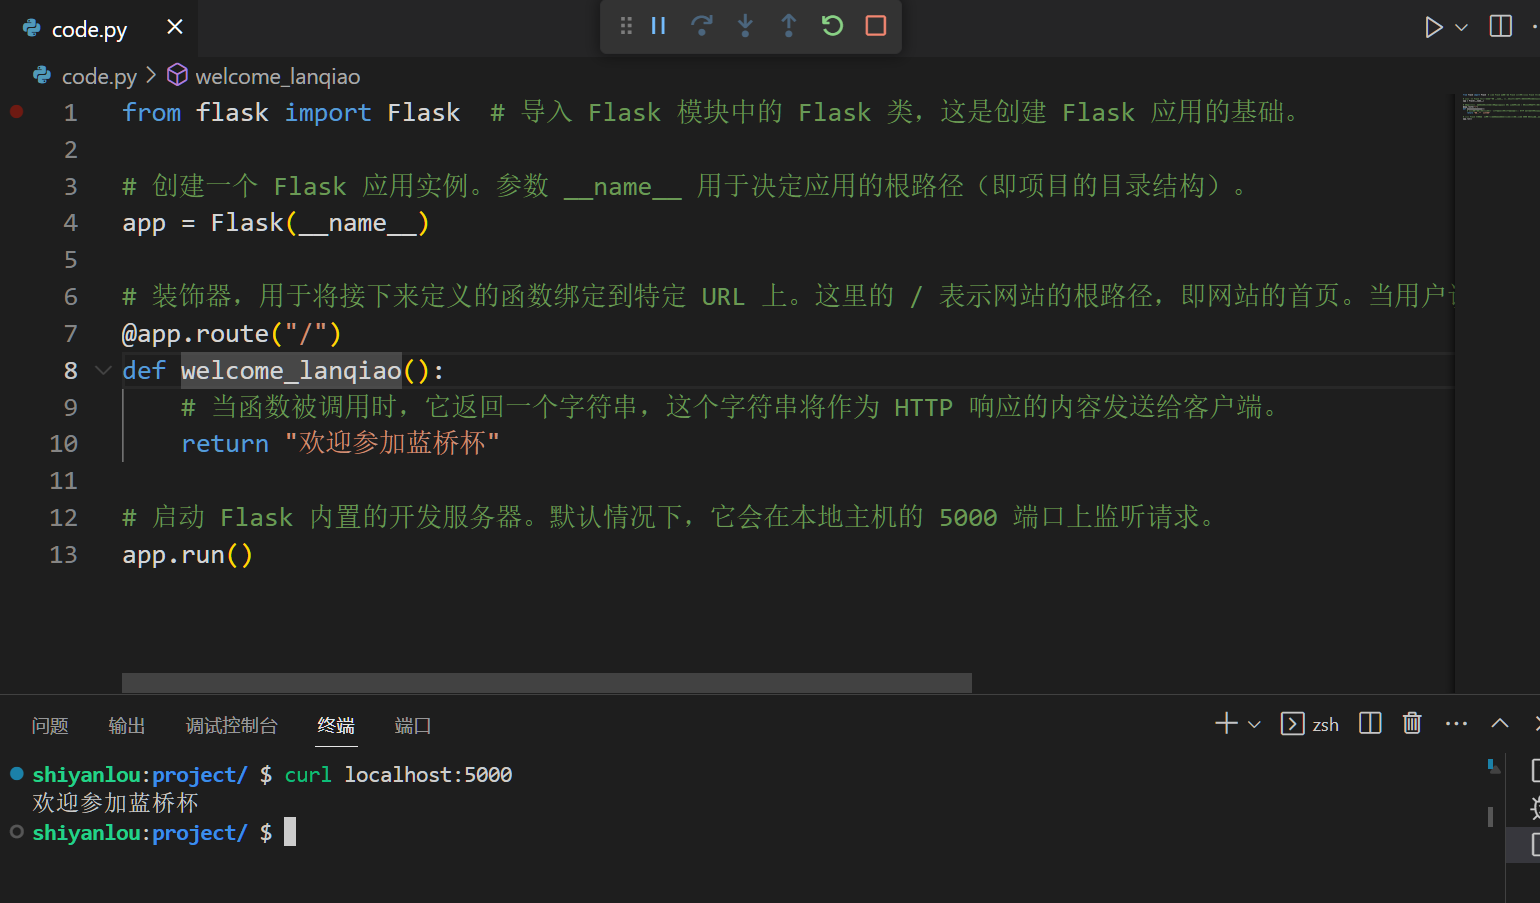

代码

```python
from flask import Flask  # 导入 Flask 模块中的 Flask 类，这是创建 Flask 应用的基础。

# 创建一个 Flask 应用实例。参数 __name__ 用于决定应用的根路径（即项目的目录结构）。
app = Flask(__name__)

# 装饰器，用于将接下来定义的函数绑定到特定 URL 上。这里的 / 表示网站的根路径，即网站的首页。当用户访问应用的根 URL 时，将会执行该装饰器下面定义的函数。
@app.route("/")
def welcome_lanqiao():
    # 当函数被调用时，它返回一个字符串，这个字符串将作为 HTTP 响应的内容发送给客户端。
    return "欢迎参加蓝桥杯"

# 启动 Flask 内置的开发服务器。默认情况下，它会在本地主机的 5000 端口上监听请求。
app.run()

```

# 直接部署

使用 Flask 直接部署机器学习模型，并提供 API 的方法非常简单，基本步骤为：先加载模型，然后从请求中获取输入数据，进行推理，最后返回推理结果。

我们先下载一个预训练模型，作为部署模型

wget -P /home/project https://labfile.oss.aliyuncs.com/courses/40981/deploy.onnx

```python
from flask import Flask, request, jsonify
import onnxruntime as ort

app = Flask(__name__)
# 加载预先训练好的 ONNX 模型
session = ort.InferenceSession('deploy.onnx')

@app.route("/")
def welcome_lanqiao():
    return "欢迎参加蓝桥杯"

# 定义路由'/predict'，并允许 POST 请求
@app.route("/predict", methods=['POST'])
def predict():
    # 从请求中获取 JSON 格式的数据，并从中提取出输入数据
    inputs = request.get_json()['inputs']
    # 使用 ONNX 会话对象执行模型推理，并获取输出结果
    output = session.run(None, {"input": inputs})[0]
    # 将输出结果转换为列表，并封装成 JSON 格式返回给客户端
    return jsonify({'output': output.tolist()})


app.run()

```

```fish
curl localhost:5000/predict --header 'Content-Type: application/json' --data '{"inputs": [[1, 1, 1, 1, 1, 1, 1,1, 1, 1]]}'

# 输出：
# {"output":[[-0.2857082188129425,0.1481000781059265,0.06945978105068207,0.0227364394813776,-0.06839977204799652]]}
```

# 热更新
在前面的代码中，我们在应用的启动时就加载了模型，而不是在每次请求的路由中动态加载。

启动时加载模型：这种方法的优势在于应用启动后，模型只会加载一次，随后的每次请求都可以直接使用已经加载的模型进行推理。这种方式减少了每次请求的延迟，提高了推理的效率。然而，缺点在于如果需要更新模型，必须重启应用，导致服务中断。
路由中动态加载模型：这种方式的优点是灵活性较高，可以随时替换模型而不需要重启应用。然而，这种方式在每次请求时都要加载模型，可能导致高频率调用场景下的性能开销增加。
如果选择在应用启动时加载模型，就不得不提到热更新。

在实际应用中，机器学习模型可能需要定期更新以适应新数据或提高性能。热更新是一种在不重启服务的情况下，动态更新模型的方法。这种方式能够在保证服务稳定性的同时，实现模型的平滑升级。这种方法特别适用于那些不允许有服务中断的高并发环境。

**提前加载模型，只能是唯一的，动态有选择地加载模型，无需重新启动应用服务，即为热更新**


# 线程安全
在实现热更新之前，我们需要了解线程安全这个关键概念。在一个多线程的应用中，比如 Flask，当多个请求同时到达时，可能会同时操作某些共享资源（如模型）。如果不加以控制，这种并发操作可能会导致数据不一致、程序崩溃或者其他难以预料的问题。

热更新的难点
当我们在应用启动时加载模型，模型实例会在内存中保持不变，所有请求都可以安全地使用这个实例进行推理。然而，当我们尝试在应用运行时更新模型时，就会面临一个挑战：如何确保在更新模型的过程中，不会有其他请求正在使用这个旧模型进行推理。这就涉及到线程安全的问题。

线程安全意味着在多线程环境下，无论有多少线程同时运行，都不会导致共享数据的不一致或应用崩溃。对于模型的热更新，如果在更新模型时恰好有另一个线程在进行推理操作，而没有进行适当的同步处理，那么可能会出现推理使用的是部分加载的新模型或部分卸载的旧模型，进而导致错误的结果或崩溃。

解决方法
为了解决这个问题，我们可以使用线程锁（threading.Lock）。线程锁是一种同步原语，它可以确保在同一时刻只有一个线程可以持有锁，从而确保在操作模型时的线程安全。在我们的应用中，锁将保证当一个线程正在更新模型时，其他线程要么等待更新完成，要么继续使用旧的模型进行推理，直到更新完成为止。

**如何保证当有人使用新模型时，无人因为使用旧的模型而导致出错 线程安全** 类似于 深度思考与联网
实现线程锁的代码
```python
from flask import Flask, request, jsonify
import onnxruntime as ort
import threading  # 导入 threading 模块，用于实现线程锁

app = Flask(__name__)

# 在应用启动时加载模型
session = ort.InferenceSession('deploy.onnx')

# 线程锁，用于在更新模型时确保线程安全
model_lock = threading.Lock()

@app.route("/")
def welcome_lanqiao():
    return "欢迎参加蓝桥杯"

@app.route("/predict", methods=["POST"])
def predict():
    # 在一个函数内部修改一个全局变量，需要使用 global 关键字来声明这个变量是在全局作用域中定义的
    global session
    inputs = request.json['inputs']

    # 加锁，确保在推理过程中模型不会被更新
    with model_lock:
        output = session.run(None, {"input": inputs})[0]

    return jsonify({'output': output.tolist(), 'model_path': session._model_path})

@app.route("/update_model", methods=["POST"])
def update_model():
    global session
    # 从请求中获取新的模型路径
    new_model_path = request.json['model_path']

    # 加锁，在更新模型时确保线程安全
    with model_lock:
        # 加载新的 ONNX 模型
        session = ort.InferenceSession(new_model_path)
    # 返回模型更新成功的消息
    return "模型已更新成功"


app.run()
``` 
**当由用户使用推理时，拒绝更换新的模型；当更换模型时，拒绝推理进行**

异步高频测试
```python
import aiohttp
import asyncio
import json

# 定义异步函数，用于发送预测请求
async def make_prediction(session, inputs):
    # 使用 aiohttp 发送 POST 请求到 Flask 服务器的 /predict 路由
    async with session.post('http://localhost:5000/predict', json={'inputs': inputs}) as response:
        # 检查请求是否成功（状态码为 200）
        if response.status == 200:
            # 如果成功，解析并打印服务器返回的 JSON 响应
            result = await response.json()
            print(f"预测结果：{result['output']}, 使用模型路径：{result['model_path']}")
        else:
            # 如果请求失败，打印错误状态码
            print(f"预测请求失败，状态码：{response.status}")

# 定义异步函数，用于发送模型更新请求
async def update_model(session, new_model_path):
    # 使用 aiohttp 发送 POST 请求到 Flask 服务器的 /update_model 路由
    async with session.post('http://localhost:5000/update_model', json={'model_path': new_model_path}) as response:
        # 检查请求是否成功（状态码为 200）
        if response.status == 200:
            # 如果成功，打印更新成功的消息
            print("模型更新成功。")
        else:
            # 如果请求失败，打印错误状态码
            print(f"模型更新失败，状态码：{response.status}")

# 定义异步函数，用于模拟高并发请求
async def simulate_high_load():
    # 创建 aiohttp 客户端会话
    async with aiohttp.ClientSession() as session:
        tasks = []  # 用于存储所有异步任务

        # 示例输入数据，用于预测请求
        inputs = [[1.0] * 10]

        # 调度多个预测请求
        for _ in range(10):
            tasks.append(make_prediction(session, inputs))

        # 在预测请求的中间调度一次模型更新请求
        tasks.append(update_model(session, 'deploy_new.onnx'))

        # 再次调度多个预测请求
        for _ in range(10):
            tasks.append(make_prediction(session, inputs))

        # 在预测请求的中间重新切回默认的模型
        tasks.append(update_model(session, 'deploy.onnx'))

        # 最后再次调度多个预测请求
        for _ in range(10):
            tasks.append(make_prediction(session, inputs))

        # 等待所有任务完成
        await asyncio.gather(*tasks)

# 运行模拟高并发请求的函数
asyncio.run(simulate_high_load())
```


# 单例模式
在进行模型加载和管理时，使用单例模式是一种常见的设计模式。单例模式确保一个类只有一个实例，并提供一个全局访问点。对于需要全局共享的资源，比如机器学习模型实例，单例模式可以避免重复加载资源、节省内存，并确保所有的请求都使用同一个模型实例。

为什么使用单例模式？
在实际应用中，特别是在多线程或多进程的场景下，单例模式可以提供以下几个优势：

减少资源消耗：只需加载一次模型，避免了重复加载造成的时间和内存浪费。
线程安全：结合线程锁等机制，确保在并发场景下的线程安全。
全局访问：可以在应用的任何地方方便地访问模型实例，而不需要多次创建或传递模型对象。

```python
import threading
import onnxruntime as ort

class ModelSingleton:
    _instance = None  # 类变量，用于保存单例对象实例
    _lock = threading.Lock()  # 创建一个锁对象用于线程安全地初始化单例

    # 重写__new__方法来控制类实例的创建
    def __new__(cls, model_path):  # 类方法的第一个参数是类 cls 本身
        with cls._lock:  # 使用锁确保线程安全
            if cls._instance is None:  # 检查是否已经创建了单例
                cls._instance = super().__new__(cls)  # 如果没有，则调用父类的__new__方法创建实例
                # 创建 ONNX 推理会话，并将模型路径与会话关联
                cls._instance.session = ort.InferenceSession(model_path)
                cls._instance.model_path = model_path  # 记录当前加载的模型路径
        # 返回单例实例
        return cls._instance

    # 更新模型的方法
    def update_model(self, new_model_path):  # 方法接受新的模型路径作为参数
        with self._lock:  # 使用锁确保线程安全
            self.session = ort.InferenceSession(new_model_path)  # 更新 ONNX 推理会话
            self.model_path = new_model_path  # 更新记录的模型路径

# 使用示例
model = ModelSingleton('deploy.onnx')
model.update_model('deploy_new.onnx')

```
在 Python 中，实现单例模式有多种方式。以下是一种简单的实现方法，适用于我们的模型加载场景。

在这个实现中，ModelSingleton 类通过 __new__ 方法控制实例的创建过程。使用线程锁 _lock 确保在多线程环境下，只有一个线程能够创建或更新实例。

# 在 Flask 中应用单例模式
结合前面的 Flask 代码，我们可以将模型的加载和更新过程改为单例模式，以确保应用在任何时候都只使用同一个模型实例。
```python
from flask import Flask, request, jsonify
import threading
import onnxruntime as ort

app = Flask(__name__)

class ModelSingleton:
    _instance = None
    _lock = threading.Lock()

    def __new__(cls, model_path):
        with cls._lock:
            if cls._instance is None:
                cls._instance = super().__new__(cls)
                cls._instance.session = ort.InferenceSession(model_path)
                cls._instance.model_path = model_path
        return cls._instance

    def update_model(self, new_model_path):
        with self._lock:
            self.session = ort.InferenceSession(new_model_path)
            self.model_path = new_model_path

# 初始化单例模型实例
model_instance = ModelSingleton('deploy.onnx')

@app.route("/")
def welcome_lanqiao():
    return "欢迎参加蓝桥杯"

@app.route("/predict", methods=["POST"])
def predict():
    inputs = request.json['inputs']

    with model_instance._lock:
        output = model_instance.session.run(None, {"input": inputs})[0]

    return jsonify({'output': output.tolist(), 'model_path': model_instance.model_path})

@app.route("/update_model", methods=["POST"])
def update_model():
    new_model_path = request.json['model_path']
    model_instance.update_model(new_model_path)
    return "模型已更新成功"

app.run()
```
在这个代码中，ModelSingleton 类负责模型的加载和更新，通过单例模式确保在整个应用生命周期中只存在一个模型实例。每次更新模型时，通过 update_model 方法实现线程安全的更新过程。

单例模式的使用不仅提高了应用的效率，还增强了代码的可维护性和扩展性。如果应用需要处理高并发请求或在多进程环境中运行，单例模式将是一个非常有效的工具。

实验总结
在本实验中，我们成功地使用 Flask 框架部署了一个机器学习模型，并探索了如何实现模型的热更新。我们深入理解了模型部署的基本流程，并在此基础上实现了两个关键功能：通过线程锁确保模型更新时的线程安全性，以及通过单例模式确保模型实例的唯一性和高效管理。

我们还通过模拟高并发场景，验证了热更新功能的有效性，确保在频繁的预测请求中模型的稳定性和可靠性，虽然模拟高并发并不是蓝桥杯中的考点，但是掌握这个工具对于高性能的模型非常有帮助。

通过这次实验不仅可以掌握 Flask 中部署模型的核心技术，还可以学会如何在实际应用中实现模型的平滑更新和优化资源管理，这些都是构建健壮、可扩展的机器学习服务的重要技能。